In [27]:
import numpy as np
import cv2
import pandas as pd
import os
import pickle
from skimage import io
from skimage.filters import roberts, sobel, scharr, prewitt
from scipy import ndimage as nd
import matplotlib.pyplot as plt

In [28]:
def feature_extraction(img):
    df = pd.DataFrame()
    
    # Feature 1: Original Image Pixels
    img2 = img.reshape(-1)
    df['Original Image'] = img2
    
    # Generate Gabor features
    num = 1
    kernels = []
    for theta in range(2):
        theta = theta / 4. * np.pi
        for sigma in (1, 3):
            for lamda in np.arange(0, np.pi, np.pi / 4):
                for gamma in (0.05, 0.5):
                    gabor_label = 'Gabor' + str(num)
                    ksize = 9
                    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)
                    kernels.append(kernel)
                    fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                    df[gabor_label] = fimg.reshape(-1)
                    num += 1
    
    # Feature 3: Canny Edge
    edges = cv2.Canny(img, 100, 200)
    df['Canny Edge'] = edges.reshape(-1)
    
    # Edge Detection Features
    df['Roberts'] = roberts(img).reshape(-1)
    df['Sobel'] = sobel(img).reshape(-1)
    df['Scharr'] = scharr(img).reshape(-1)
    df['Prewitt'] = prewitt(img).reshape(-1)
    
    # Gaussian and Median Filters
    df['Gaussian s3'] = nd.gaussian_filter(img, sigma=3).reshape(-1)
    df['Gaussian s7'] = nd.gaussian_filter(img, sigma=7).reshape(-1)
    df['Median s3'] = nd.median_filter(img, size=3).reshape(-1)
    
    return df

Processing: 448_images_512x512.tif
Processing: sandstone_train_images.tif
Processing: train_imgs_cropped_768.tif


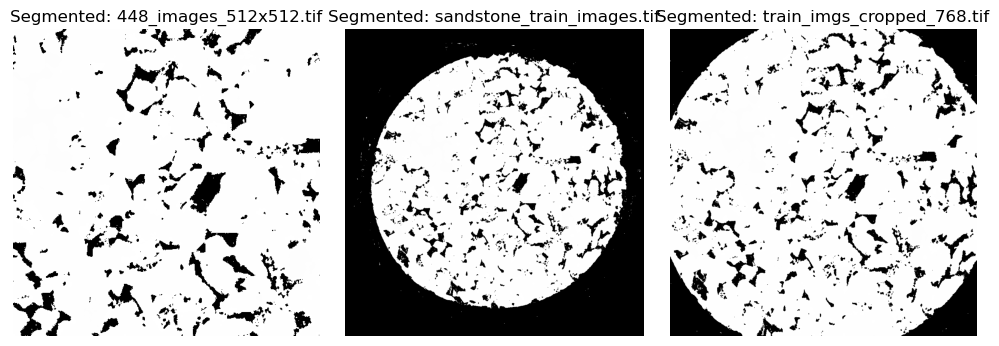

Segmentation completed!


In [35]:
filename = "sandstone_model"
loaded_model = pickle.load(open(filename, 'rb'))

input_path = "C:/Users/zidan/Downloads/Compressed/sandstone_data_for_ML/test_images"
output_path = "C:/Users/zidan/Downloads/Compressed/sandstone_data_for_ML/segemented_images"
os.makedirs(output_path, exist_ok=True)

# Prepare figure for visualization
plt.figure(figsize=(10, 10))

# Process each image
for i, image in enumerate(os.listdir(input_path), 1):
    print(f"Processing: {image}")
    
    img1 = cv2.imread(os.path.join(input_path, image))
    img = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    
    # Extract features
    X = feature_extraction(img)
    
    # Predict segmentation
    result = loaded_model.predict(X)
    segmented = result.reshape(img.shape).astype(np.uint8) * 255  # Normalize values
    
    # Save segmented image
    io.imsave(os.path.join(output_path, image), segmented, check_contrast=False)
    
    # Optional: Show result
    plt.subplot(3, 3, i)
    plt.imshow(segmented, cmap='gray')
    plt.title(f"Segmented: {image}")
    plt.axis('off')

# Show all segmented images after processing
plt.tight_layout()
plt.show()

print("Segmentation completed!")